<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/CV/ImageAugmentationOnline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Weather Augmentation with OpenCV and Albumentations

This code demonstrates various weather augmentation techniques using OpenCV and Albumentations libraries. It includes functions to add shadiness, snow, rain, fog, and combined snow and rain effects to an image. The code also utilizes the Albumentations library for rain augmentation. The image is loaded, converted to the RGB colorspace, and then passed through the different weather augmentation functions to generate the desired effects. The resulting images are displayed using matplotlib.

## Metrics

In [1]:
!pip install -q lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.4 MB/s eta 0:00:00


In [11]:
import cv2
import torch
import numpy as np
from PIL import Image
from math import log10
from lpips import LPIPS
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim

class MetricsCalculator:
  def __init__(self):
      self.lpips_model = LPIPS(net='alex')

  # ----------------- #
  #   Client metrics  #
  # ----------------- #
  def compute_lpips(self, original_img, modified_img):
      image1 = transforms.ToTensor()(original_img) * 2 - 1
      image2 = transforms.ToTensor()(modified_img) * 2 - 1
      distance = self.lpips_model.forward(image1, image2)
      return distance.item()

  def image_entropy(self, img):
      histogram = np.histogram(img, bins=256, range=(0, 255))[0]
      probabilities = histogram / float(np.sum(histogram))
      probabilities = probabilities[np.nonzero(probabilities)]
      entropy = -np.sum(probabilities * np.log2(probabilities))
      return entropy

  def compute_entropy_difference(self, original_img, modified_img):
      entropy1 = self.image_entropy(original_img)
      entropy2 = self.image_entropy(modified_img)
      entropy_difference = abs(entropy1 - entropy2)
      return entropy_difference

  # ----------------- #
  #   SOTA metrics    #
  # ----------------- #
  def PSNR(self, img1, img2):
      mse = self.MSE(img1, img2)
      if mse == 0:
          return 100
      max_pixel = 255.0
      psnr = 10 * log10(max_pixel**2 / mse)
      return psnr

  def similarity(self, img1, img2):
      if len(img1.shape) == 3:
          img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
      if len(img2.shape) == 3:
          img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
      similarity = ssim(img1, img2)
      return similarity

  def MSE(self, img1, img2):
      mse = np.mean((img1 - img2) ** 2)
      return mse

  def MAE(self, img1, img2):
      mae = np.mean(np.abs(img1 - img2))
      return mae


## Detect day, affternoon or nigth

afternoon


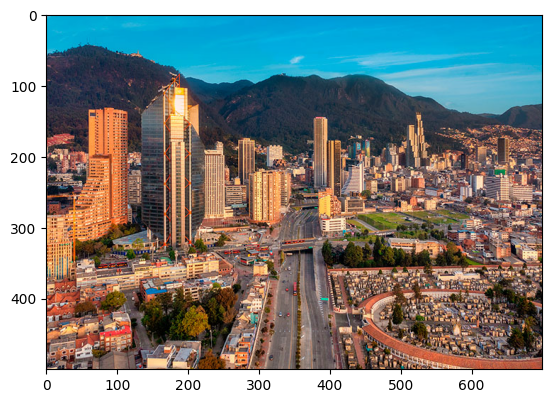

night


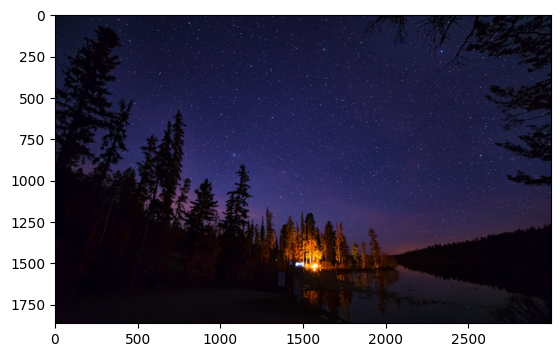

day


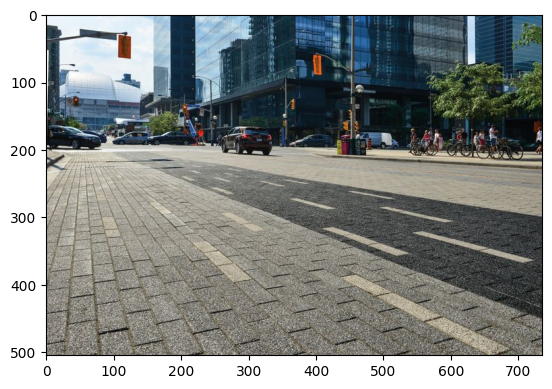

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def detect_time_of_day(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  frame = img

  brightness = np.sum(np.sum(frame)) / (frame.shape[0] * frame.shape[1] * frame.shape[2])

  if brightness > 110.0:
      return 'day', frame
  elif 90.0 < brightness < 110:
      return 'afternoon', frame
  else:
        return 'night', frame

image_path_afternoon = "/content/Destacado_Que-tanto-sabes-de-tu-barrio.jpg"
image_path_nigth = '/content/nigth.jpg'
image_path_day = '/content/img.jpg'


time_of_day, frame = detect_time_of_day(image_path_afternoon)
print(time_of_day)
plt.imshow(frame)
plt.show()

time_of_day, frame = detect_time_of_day(image_path_nigth)
print(time_of_day)
plt.imshow(frame)
plt.show()

time_of_day, frame = detect_time_of_day(image_path_day)
print(time_of_day)
plt.imshow(frame)
plt.show()

## Weather transformations

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

img = cv2.imread("/content/img.jpg")
#img = cv2.imread("/content/noche_bog.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB colorspace


def add_shadiness(image):
  '''This function adds shadiness to the image by adjusting
  the brightness of   the image using the HLS colorspace.
  It randomly scales the lightness channel (L) of the image
  to create a shadier appearance.'''
  image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  image_HLS = image_HLS.astype(np.float64)
  random_brightness_coefficient = np.random.uniform(0.4, 0.9)
  image_HLS[:, :, 1] *= random_brightness_coefficient
  image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255
  image_HLS = image_HLS.astype(np.uint8)
  image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)
  return image_RGB


def add_snow(image):
  '''This function adds a snow effect to the image.
  It generates random snowflakes and combines them
  with the image. The brightness of the image is
  adjusted based on the snow accumulation, and the
  snowflakes are blended with the image using the
  cv2.addWeighted() function.
  '''
  snow_layer = np.random.normal(size=image.shape[:2], loc=255, scale=10)
  snow_layer = np.clip(snow_layer, 0, 255)
  snow_layer = np.repeat(snow_layer[:, :, np.newaxis], 3, axis=2).astype(np.uint8)

  image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  image_HLS = image_HLS.astype(np.float64)
  brightness_coefficient = 2.5
  snow_point = 160  # Increase this for more snow
  image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] *= brightness_coefficient
  image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255
  image_HLS = image_HLS.astype(np.uint8)
  image_snow_accumulation = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

  image_snow = cv2.addWeighted(image_snow_accumulation, 0.7, snow_layer, 0.3, 0)
  return image_snow




def add_snow_2(image, rain_density=0.1, rain_length=1, rain_angle=-30, rain_thickness=1):
  ''' This function adds snowflakes to the image by drawing
  random lines on the image. The snowflakes are drawn using
  the cv2.line() function, and the resulting image with
  snowflakes is returned.
  '''
  image_rain = image.copy()
  image_height, image_width = image.shape[:2]
  num_raindrops = int(rain_density * image_height * image_width)

  for _ in range(num_raindrops):
      start_point = (np.random.randint(0, image_width), np.random.randint(0, image_height))
      end_point = (int(start_point[0] - rain_length * np.cos(np.deg2rad(rain_angle))),
                    int(start_point[1] - rain_length * np.sin(np.deg2rad(rain_angle))))
      cv2.line(image_rain, start_point, end_point, (255, 255, 255), thickness=rain_thickness)

  return image_rain


def add_snow_3(image, snow_density=0.1, snow_length=20, snow_angle=-30, snow_thickness=1):
  ''' This function is similar to add_snow() but includes
  additional parameters to control the density, length,
  angle, and thickness of the snowflakes.
  '''
  snow_layer = np.random.normal(size=image.shape[:2], loc=255, scale=10)
  snow_layer = np.clip(snow_layer, 0, 255)
  snow_layer = np.repeat(snow_layer[:, :, np.newaxis], 3, axis=2).astype(np.uint8)

  image_height, image_width = image.shape[:2]
  num_snowflakes = int(snow_density * image_height * image_width)

  for _ in range(num_snowflakes):
      start_point = (np.random.randint(0, image_width), np.random.randint(0, image_height))
      end_point = (int(start_point[0] - snow_length * np.cos(np.deg2rad(snow_angle))),
                    int(start_point[1] - snow_length * np.sin(np.deg2rad(snow_angle))))
      cv2.line(snow_layer, start_point, end_point, (255, 255, 255), thickness=snow_thickness)

  image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  image_HLS = image_HLS.astype(np.float64)
  brightness_coefficient = 2.5
  snow_point = 160  # Increase this for more snow
  image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] *= brightness_coefficient
  image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255
  image_HLS = image_HLS.astype(np.uint8)
  image_snow_accumulation = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

  image_snow = cv2.addWeighted(image_snow_accumulation, 0.7, snow_layer, 0.3, 0)
  return image_snow


def add_rain(image):
  ''' This function adds a rain effect to the image using the Albumentations
  library. It applies a random rain transformation to the image using the
  RandomRain class from Albumentations.'''
  rain_transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1)
  transformed = rain_transform(image=image)
  return transformed['image']



def add_fog(image, fog_intensity=0.5, fog_color=(255, 255, 255)):
  ''' This function adds a fog effect to the image. It creates a fog layer
  and blends it with the image using the cv2.addWeighted() function. The
  fog layer is generated by applying a Gaussian blur to an alpha mask.
  '''
  fog_layer = np.full(image.shape, fog_color, dtype=np.uint8)
  fog_alpha = np.zeros(image.shape[:2], dtype=np.float64)
  fog_alpha = cv2.GaussianBlur(fog_alpha, (101, 101), 30)
  max_alpha = np.max(fog_alpha)
  if max_alpha == 0:
      return image.copy()
  fog_alpha = fog_intensity * fog_alpha / max_alpha
  fog_alpha = np.repeat(fog_alpha[:, :, np.newaxis], 3, axis=2)
  image_fog = cv2.addWeighted(image.astype(np.float64), 1 - fog_alpha, fog_layer.astype(np.float64), fog_alpha, 0)
  return image_fog.astype(np.uint8)



def add_snow_and_rain(image, snow_density=0.1, snow_length=20, snow_angle=-30, snow_thickness=1):
  '''This function combines the snow effect and the rain effect. It first applies
  the snow effect to the image and then adds raindrops using the add_snow_2() function.'''
  snow_layer = np.random.normal(size=image.shape[:2], loc=255, scale=10)
  snow_layer = np.clip(snow_layer, 0, 255)
  snow_layer = np.repeat(snow_layer[:, :, np.newaxis], 3, axis=2).astype(np.uint8)

  image_height, image_width = image.shape[:2]
  num_snowflakes = int(snow_density * image_height * image_width)

  for _ in range(num_snowflakes):
      start_point = (np.random.randint(0, image_width), np.random.randint(0, image_height))
      end_point = (int(start_point[0] - snow_length * np.cos(np.deg2rad(snow_angle))),
                    int(start_point[1] - snow_length * np.sin(np.deg2rad(snow_angle))))
      cv2.line(snow_layer, start_point, end_point, (255, 255, 255), thickness=snow_thickness)

  image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  image_HLS = image_HLS.astype(np.float64)
  brightness_coefficient = 2.5
  snow_point = 160  # Increase this for more snow
  image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] *= brightness_coefficient
  image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255
  image_HLS = image_HLS.astype(np.uint8)
  image_snow_accumulation = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

  image_snow = cv2.addWeighted(image_snow_accumulation, 0.7, snow_layer, 0.3, 0)

  image_snow_rain = add_snow_2(image_snow, rain_density=0.1, rain_length=1, rain_angle=-30, rain_thickness=1)

  return image_snow_rain


def day_to_night(img):
  arr = img * np.array([0.1,0.2,0.5])
  arr2 = (255*arr/arr.max()).astype(np.uint8)
  gamma = 2
  img_nigth = np.array(255*(arr2/255)**gamma, dtype = 'uint8')
  return img_nigth


def detect_time_of_day(image):
    brightness = np.sum(np.sum(image)) / (image.shape[0] * image.shape[1] * image.shape[2])

    if brightness > 110.0:
        return 'day'
    elif 90.0 < brightness < 110:
        return 'afternoon'
    else:
        return 'night'

def apply_blur_with_rain(image):
    image_rain = add_rain(image)
    blurred_image = cv2.GaussianBlur(image_rain, (25, 25), 0)
    return blurred_image

def apply_foggy_with_rain(image):
    image_rain = add_rain(image)
    foggy_image = add_fog(image_rain, fog_intensity=0.7)
    return foggy_image

Detected time of day: day


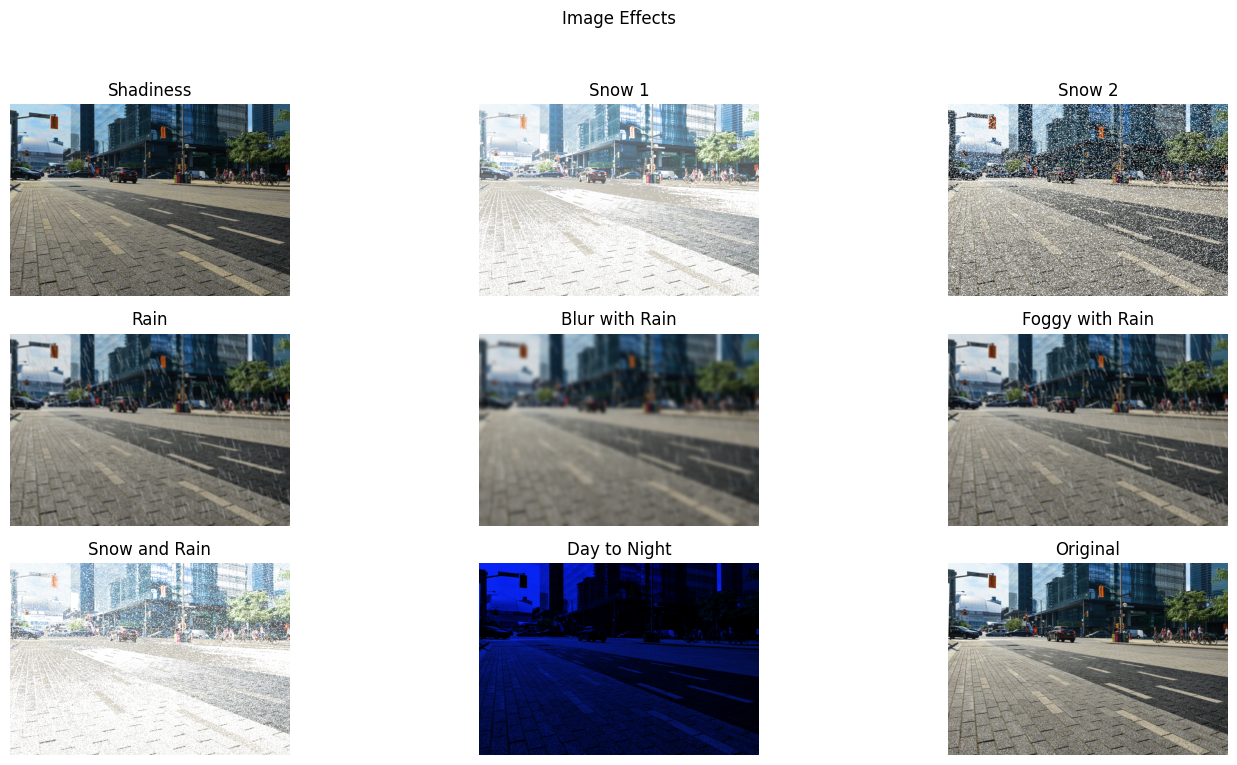

In [10]:
def execute_effects_and_plot(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    time_of_day = detect_time_of_day(img)
    print(f"Detected time of day: {time_of_day}")

    effects = [
        ("Shadiness", add_shadiness),
        ("Snow 1", add_snow),
        ("Snow 2", add_snow_2),
        ("Rain", add_rain),
        ("Blur with Rain", apply_blur_with_rain),
        ("Foggy with Rain", apply_foggy_with_rain),
        ("Snow and Rain", add_snow_and_rain),
        ("Day to Night", day_to_night)
    ]

    num_effects = len(effects)
    num_cols = 3  # Adjust this number based on how many columns you want in the grid
    num_rows = (num_effects + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    fig.suptitle("Image Effects")

    for idx, (effect_name, effect_func) in enumerate(effects):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]

        if effect_name == "Day to Night":
            effect_img = effect_func(img.copy())
        else:
            effect_img = effect_func(img)

        ax.imshow(effect_img)
        ax.set_title(effect_name)
        ax.axis("off")

    # Display the original image separately without applying any effect
    row = num_effects // num_cols
    col = num_effects % num_cols
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title("Original")
    ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with your image path
execute_effects_and_plot("/content/img.jpg")


Detected time of day: day
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


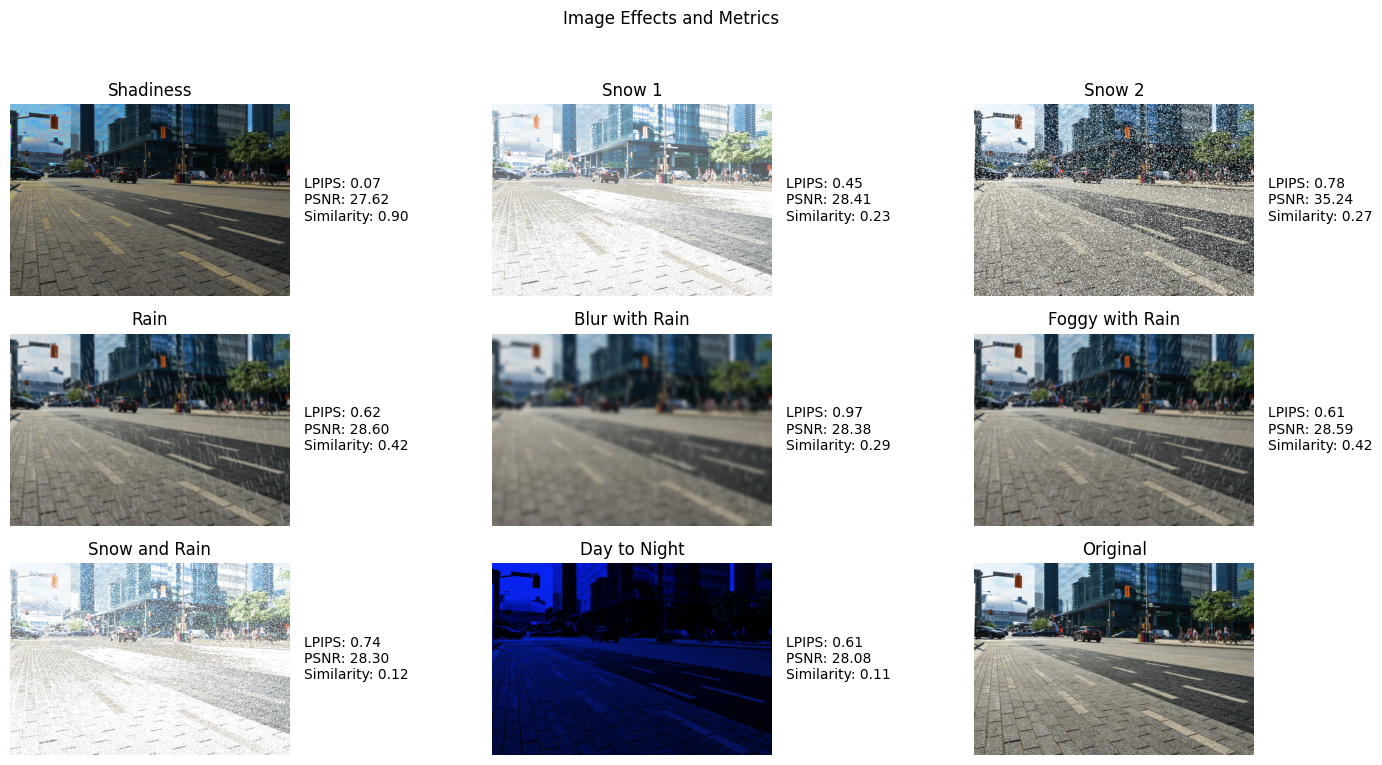

In [14]:
def execute_effects_and_plot(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    time_of_day = detect_time_of_day(img)
    print(f"Detected time of day: {time_of_day}")

    effects = [
        ("Shadiness", add_shadiness),
        ("Snow 1", add_snow),
        ("Snow 2", add_snow_2),
        ("Rain", add_rain),
        ("Blur with Rain", apply_blur_with_rain),
        ("Foggy with Rain", apply_foggy_with_rain),
        ("Snow and Rain", add_snow_and_rain),
        ("Day to Night", day_to_night)
    ]

    num_effects = len(effects)
    num_cols = 3  # Adjust this number based on how many columns you want in the grid
    num_rows = (num_effects + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    fig.suptitle("Image Effects and Metrics")

    metrics_calculator = MetricsCalculator()  # Create an instance of the MetricsCalculator class

    for idx, (effect_name, effect_func) in enumerate(effects):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]

        if effect_name == "Day to Night":
            effect_img = effect_func(img.copy())
        else:
            effect_img = effect_func(img)

        ax.imshow(effect_img)
        ax.set_title(effect_name)
        ax.axis("off")

        # Compute metrics for the effect
        lpips_score = metrics_calculator.compute_lpips(img, effect_img)
        psnr_score = metrics_calculator.PSNR(img, effect_img)
        similarity_score = metrics_calculator.similarity(img, effect_img)

        # Display metrics on the right side of the image
        metrics_text = f"LPIPS: {lpips_score:.2f}\nPSNR: {psnr_score:.2f}\nSimilarity: {similarity_score:.2f}"
        ax.text(1.05, 0.5, metrics_text, transform=ax.transAxes, va="center")

    # Display the original image separately without applying any effect
    row = num_effects // num_cols
    col = num_effects % num_cols
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title("Original")
    ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with your image path
execute_effects_and_plot("/content/img.jpg")



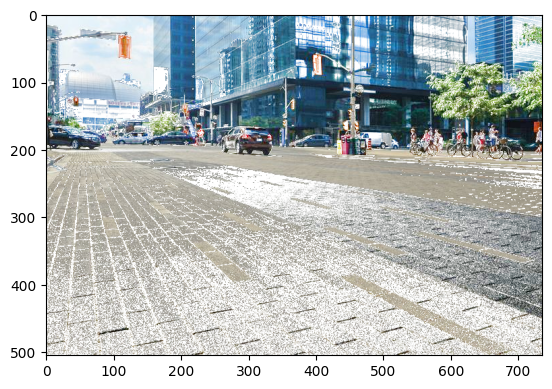

In [ ]:
def add_snow_page(image):
  image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
  image_HLS = np.array(image_HLS, dtype = np.float64)
  brightness_coefficient = 2.5
  snow_point=140 ## increase this for more snow
  image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
  image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
  image_HLS = np.array(image_HLS, dtype = np.uint8)
  image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
  return image_RGB

def add_blur(image, x,y,hw):
  image[y:y+hw, x:x+hw,1] = image[y:y+hw, x:x+hw,1]+1
  image[:,:,1][image[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
  image[y:y+hw, x:x+hw,1] = cv2.blur(image[y:y+hw, x:x+hw,1] ,(10,10))
  return image



img9 = add_snow_page(img)
plt.imshow(img9)

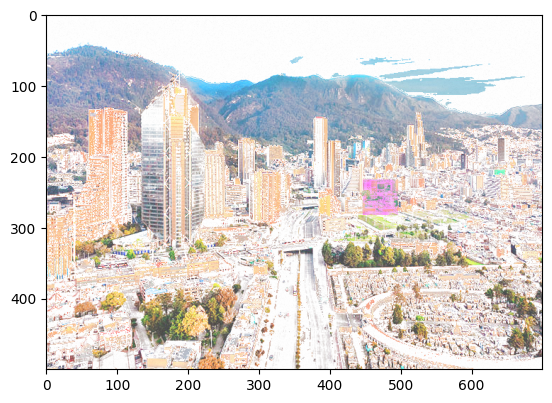

In [ ]:
def add_snow_blur(image):
    image_height, image_width = image.shape[:2]
    hw = min(image_height, image_width) // 10  # Set the size of the blur region as 1/10th of the minimum dimension
    x = np.random.randint(0, image_width - hw)  # Randomly select x within the image bounds
    y = np.random.randint(0, image_height - hw)  # Randomly select y within the image bounds

    image_snow = add_snow(image)
    image_snow_blur = add_blur(image_snow, x, y, hw)
    return image_snow_blur

img10 = add_snow_blur(img)
plt.imshow(img10)




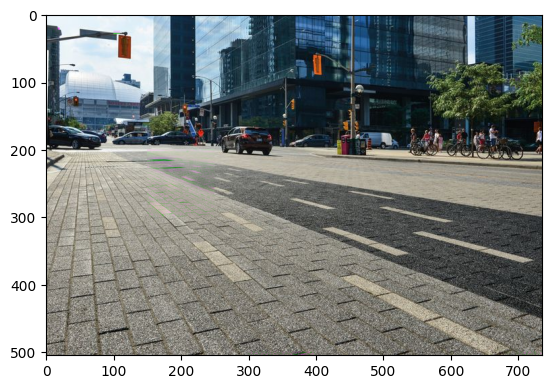

In [ ]:
def add_windy_snow(image):
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image_HLS = np.array(image_HLS, dtype=np.float64)

    brightness_coefficient = 1.5
    snow_point = 180
    image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] = image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] * brightness_coefficient
    image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255

    image_HLS = np.array(image_HLS, dtype=np.uint8)
    image_snow = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

    image_blur = image.copy()
    x, y, hw = 100, 100, 100  # Example values for region of interest
    image_blur[y:y + hw, x:x + hw, 1] = image_blur[y:y + hw, x:x + hw, 1] + 1
    image_blur[:, :, 1][image_blur[:, :, 1] > 255] = 255
    image_blur[y:y + hw, x:x + hw, 1] = cv2.blur(image_blur[y:y + hw, x:x + hw, 1], (10, 10))

    combined_image = cv2.addWeighted(image_snow, 0.5, image_blur, 0.5, 0)

    return combined_image


img10 = add_blur(img,700,500,500)
plt.imshow(img10)




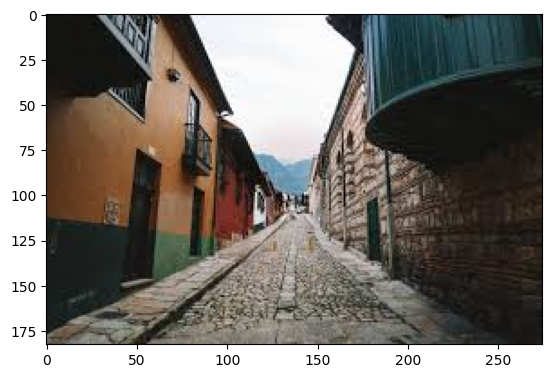

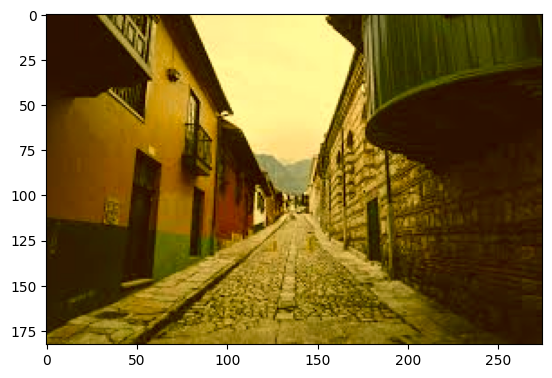

In [ ]:
sample_nigth = cv2.imread("/content/nigth.jpg")
sample_nigth = cv2.cvtColor(sample_nigth, cv2.COLOR_BGR2RGB)

def convert_day_to_night(image, nigth_sample):
  a = img*np.array([0.1,0.2,0.5])
  b = (255*a/a.max()).astype(np.uint8)
  gamma = 0.3
  nigth_img = np.array(255*(nigth_sample/255)**gamma,dtype='uint8')
  return nigth_img

from imageio import imread





def day_to_night_2(image):
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab_planes = list(lab_planes)  # Convert the tuple to a list
  lab_planes[0] = cv2.subtract(lab_planes[0], 90)  # Adjust the lightness channel to darken the image
  lab = cv2.merge(lab_planes)
  night_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return night_image



def convert_white_to_yellow(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab_planes = list(cv2.split(lab))  # Convert the tuple to a list
    lab_planes[2] = cv2.add(lab_planes[2], 70)  # Adjust the B channel to increase the yellow color
    lab = cv2.merge(lab_planes)
    yellow_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return yellow_image


def convert_white_to_yellow(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab_planes = cv2.split(lab)
    lab_planes = list(lab_planes)  # Convert the tuple to a list
    lab_planes[2] = cv2.add(lab_planes[2], 50)  # Adjust the B channel to increase the yellow color
    lab = cv2.merge(lab_planes)
    yellow_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return yellow_image

img = cv2.imread("/content/images.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert day to night
night_image = convert_white_to_yellow(img)

plt.imshow(img)
plt.show()
plt.imshow(night_image)
plt.show()


